# Star Separation Test

### Motivation 

A notebook to test the performance of comcam close loop (estimation of Zernike polynomials from the Wavefront Estimation Calculation pipeline) as the simulated stars are brought closer together,  possibly bringing us to the regime of overlapping donuts. 

### Performance Metric 

The RMS value between OPD results and the Zernike polynomials given by ts_wep output.

### Test Data 

Created on UW *epyc*, in `ts_phosim/notebooks/analysis_scripts/output/` running `runSeparationAnalysis.py` in the `ts_phosim/notebooks/analysis_scripts` directory.


## Setup 

In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import os
import sys
sys.path.append('../analysis_tools/')
from calcMetrics import calcMetrics


In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
import os
import argparse
import numpy as np

from lsst.ts.wep.ParamReader import ParamReader
from lsst.ts.wep.Utility import FilterType

from lsst.ts.ofc.Utility import InstName
from lsst.ts.ofc.ctrlIntf.OFCCalculationFactory import OFCCalculationFactory

from lsst.ts.phosim.SkySim import SkySim
from lsst.ts.phosim.OpdMetrology import OpdMetrology
from lsst.ts.phosim.Utility import getAoclcOutputPath, getConfigDir

import matplotlib.pyplot as plt
import matplotlib.cm as cm 

0.21000000000000002
0.18500000000000003
0.16000000000000003
0.135
0.11
0.085
0.060000000000000005
0.035
0.01


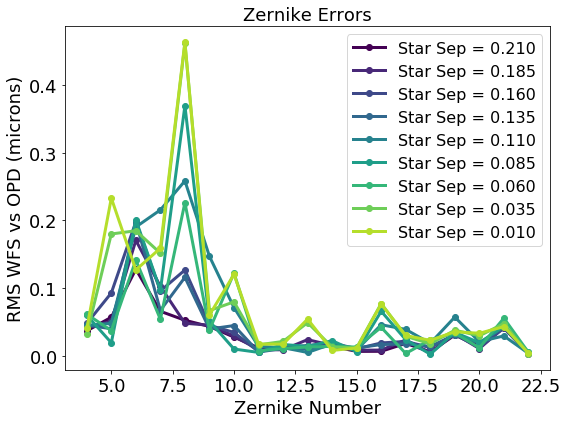

In [35]:
%matplotlib inline

data_dir = '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/'




ssrTotalVals = []
ssrFieldVals = []
zernikeErrors = []

calcMagMetrics = calcMetrics()

sepArr = np.arange(0.01, 0.23, 0.025 )[::-1]

N = len(sepArr)
colors = (np.arange(N+1)/N) 
cmap = cm.get_cmap('viridis') 


for sep in sepArr :
    print(sep)
    opdZkFilePath = os.path.join(data_dir, 'opd.zer.sep.%.3f'%sep)
    wfsZkFilePath = os.path.join(data_dir, 'wfs.zer.sep.%.3f'%sep)
    opdData, wfsData = calcMagMetrics.loadZernikeData(opdZkFilePath, wfsZkFilePath)
    opdData = opdData[:3]
    wfsData = wfsData[:3]
    zernikeErrors.append(np.sqrt((wfsData - opdData)**2.))
    
    
    # calculate sum of squared residuals : 
    # zerFieldSSR = np.sum((wfsZkData - opdZkData)**2, axis=1)
    # zerTotalSSR = np.sum(zerFieldSSR)
    zerFieldSSR, zerTotalSSR = calcMagMetrics.calcSSR(opdData, wfsData)
    ssrFieldVals.append(zerFieldSSR)
    ssrTotalVals.append(zerTotalSSR)

zernikeErrors = np.array(zernikeErrors)
zernikeErrors = np.transpose(zernikeErrors, axes=(2,1,0))


fig = plt.figure(figsize=(8,6))

for i in range(len(sepArr)):
    plt.plot(np.arange(19)+4, np.sqrt(np.mean(np.square(zernikeErrors), axis=1)[:, i]), 
             '-o', lw=3, label='Star Sep = %.3f' % sepArr[i],color = cmap(colors[i]) )
    plt.xlabel('Zernike Number', size=18)
    plt.ylabel('RMS WFS vs OPD (microns)', size=18)
    plt.xticks(size=18)
    plt.yticks(size=18)
plt.legend(fontsize=16)
plt.title('Zernike Errors', size=18)
    
plt.tight_layout()

Show what the images look like... 

In [36]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.animation as animation
from IPython.display import IFrame, display, Markdown, HTML
import lsst.daf.persistence as dafPersist
import lsst.daf.base        as dafBase
import lsst.afw.table as afwTable
from lsst.meas.algorithms.detection    import SourceDetectionTask
from lsst.meas.base import NoiseReplacer, NoiseReplacerConfig
import lsst.afw.detection as afwDetection
import lsst.afw.display as afwDisplay

from lsst.geom import Extent2D, Point2D, SpherePoint
from lsst.geom import degrees as geomDeg

In [130]:
#data_dir = '/astro/store/epyc/projects/lsst_comm/ts_phosim/notebooks/analysis_data/sample_output/overlap_19_output/'
data_dir = '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/output/sep_0.185/'
#repo_dir = os.path.join(data_dir, 'input')
repo_dir = os.path.join(data_dir, 'input')
butler = dafPersist.Butler(repo_dir)
data_id = {'visit': 9006001, 'filter': 'g', 'raftName': 'R22', 'detectorName': 'S00'}
raw = butler.get('raw', **data_id)  # doesn't show anything ...  ? 

Ignoring Error calculating property 'boresight_airmass' using translator <class 'lsst.obs.lsst.translators.phosim.PhosimTranslator'>: "Could not find ['AIRMASS'] in header"
Ignoring Error calculating property 'temperature' using translator <class 'lsst.obs.lsst.translators.phosim.PhosimTranslator'>: "Could not find ['TEMPERA'] in header"
Ignoring Error calculating property 'pressure' using translator <class 'lsst.obs.lsst.translators.phosim.PhosimTranslator'>: "Could not find ['PRESS'] in header"


In [ ]:
raw.image.

In [204]:
np.shape(raw.image.array)

(4020, 4176)

(array([  7., 127., 455., 391., 174., 603., 903., 985., 480.,  51.]),
 array([ 961. ,  966.9,  972.8,  978.7,  984.6,  990.5,  996.4, 1002.3,
        1008.2, 1014.1, 1020. ], dtype=float32),
 <a list of 10 Patch objects>)

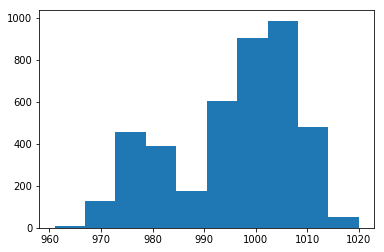

In [178]:
plt.hist(raw.image.array[24])

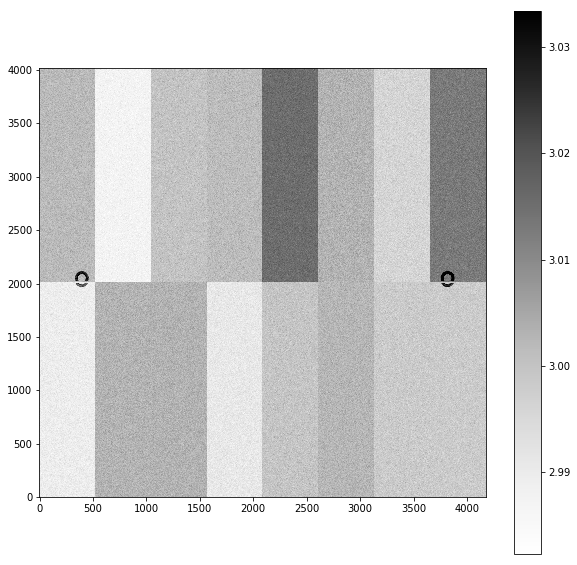

In [203]:
# Plot image array
fig = plt.figure(figsize=(10,10))

plt.imshow(np.log10(raw.image.array),vmin = np.log10(960), 
           vmax=np.log10(1080), cmap=cm.get_cmap('Greys'),
          origin='lower')
plt.colorbar()

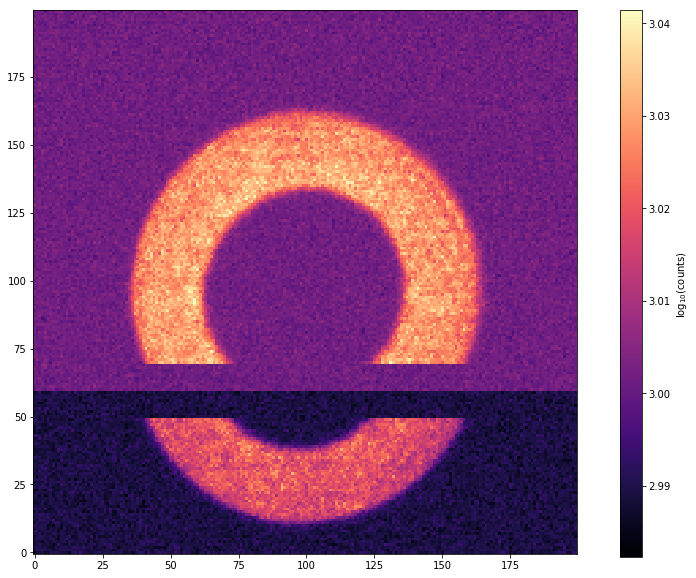

In [248]:
xmin,xmax = 300,500
ymin,ymax = 1950,2150
# Plot image array
fig,ax = plt.subplots(1,1,figsize=(10,10))

left,bottom,width,height = .95, 0.12, 0.03, 0.76

cax = fig.add_axes([left,bottom,width,height], yticks=[], )

    
image = ax.imshow(np.log10(raw.image.array[ymin:ymax, xmin:xmax]),vmin = np.log10(960), 
           vmax=np.log10(1100), cmap=cm.get_cmap('magma'),
          origin='lower')
plt.colorbar(image, cax=cax,label=r'$\log_{10}(\mathrm{counts})$' )



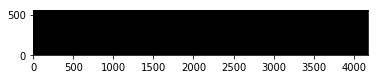

In [207]:
plt.imshow(raw.image.array[0:560,0:],vmin = np.log10(960), 
           vmax=np.log10(1080), cmap=cm.get_cmap('Greys'), origin='lower')

In [188]:
# set up minimal detection task
schema = afwTable.SourceTable.makeMinimalSchema()
config = SourceDetectionTask.ConfigClass()
config.thresholdValue = 800   # detection threshold in units of thresholdType
config.thresholdType = "value"#"stdev"   # units for thresholdValue

sourceDetectionTask = SourceDetectionTask(config=config)

In [189]:
footprint_set = sourceDetectionTask.detectFootprints(raw, sigma=1.)

RuntimeError: 
  File "src/math/Approximate.cc", line 178, in lsst::afw::math::{anonymous}::ApproximateChebyshev<PixelT>::ApproximateChebyshev(const std::vector<double>&, const std::vector<double>&, const lsst::afw::image::MaskedImage<ImagePixelT1, int, float>&, const lsst::geom::Box2I&, const lsst::afw::math::ApproximateControl&) [with PixelT = float]
    No valid points to fit. Variance is likely zero. Try weighting=False {0}
lsst::pex::exceptions::RuntimeError: 'No valid points to fit. Variance is likely zero. Try weighting=False'


In [100]:
data_dir = '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/output/sep_0.185/'
path = data_dir + 'iter0/img/extra/'
filter_dic = {'g':1, 'r':2, 'i':3}  # etc 
fname = 'lsst_a_%d_f%d_%s_%s_E000.fits'%(data_id['visit'],filter_dic[data_id['filter']], data_id['raftName'],
                               data_id['detectorName'],)
print(fname)

#lsst_a_9006001_f1_R22_S12_E000.fits

lsst_a_9006001_f1_R22_S00_E000.fits


In [62]:
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename

#https://docs.astropy.org/en/stable/visualization/wcsaxes/
from astropy.wcs import WCS

In [101]:
filename = get_pkg_data_filename(path+fname)
hdu = fits.open(filename)[1]
wcs = WCS(hdu.header)
#hdu = fits.open(path+fname)

In [104]:
hdu = fits.open(filename)
hdu.info()

Filename: /epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/output/sep_0.185/iter0/img/extra/lsst_a_9006001_f1_R22_S00_E000.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      21   ()      
  1  Segment10     1 ImageHDU       938   (522, 2010)   int32 (rescales to uint32)   
  2  Segment11     1 ImageHDU       938   (522, 2010)   int32 (rescales to uint32)   
  3  Segment12     1 ImageHDU       938   (522, 2010)   int32 (rescales to uint32)   
  4  Segment13     1 ImageHDU       938   (522, 2010)   int32 (rescales to uint32)   
  5  Segment14     1 ImageHDU       938   (522, 2010)   int32 (rescales to uint32)   
  6  Segment15     1 ImageHDU       938   (522, 2010)   int32 (rescales to uint32)   
  7  Segment16     1 ImageHDU       938   (522, 2010)   int32 (rescales to uint32)   
  8  Segment17     1 ImageHDU       938   (522, 2010)   int32 (rescales to uint32)   
  9  Segment07     1 ImageHDU       938   (5

In [121]:
hdu[1].header['NAXIS1']

522

In [65]:
#one way 

#hdu = fits.open(path+fname)
#hdu.info()
#image_data = hdu[1].data
# print(type(image_data))
# print(image_data.shape)
# plt.imshow(image_data, cmap='gray')
# plt.colorbar()

/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/output/sep_0.185/iter0/img/extra/lsst_a_9006001_f1_R22_S00_E000.fits


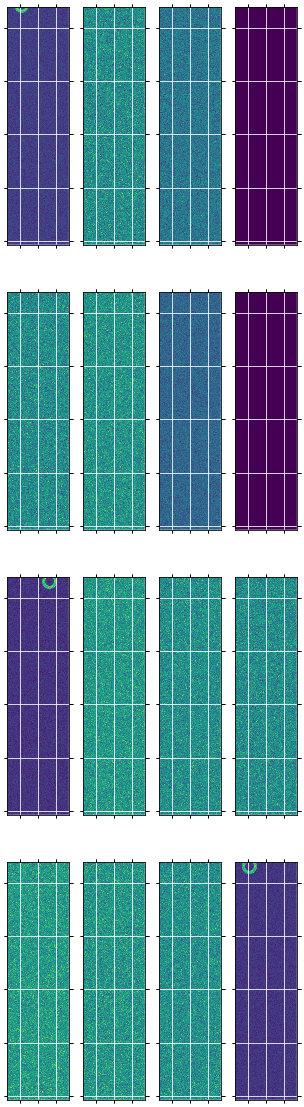

In [126]:


data_dir = '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/output/sep_0.185/'
path = data_dir + 'iter0/img/extra/'
filter_dic = {'g':1, 'r':2, 'i':3}  # etc 
fname = 'lsst_a_%d_f%d_%s_%s_E000.fits'%(data_id['visit'],filter_dic[data_id['filter']], data_id['raftName'],
                               data_id['detectorName'],)
filename = get_pkg_data_filename(path+fname)
print(path+fname)


hdu = fits.open(filename)

xpx = hdu[1].header['NAXIS1']
ypx = hdu[1].header['NAXIS2']

fig,axs = plt.subplots(4,4,subplot_kw={'projection':wcs, 
                                      'label':'overlays'}, 
                      figsize=(xpx/100, ypx/100))
ax = np.ravel(axs)

for i in range(1,len(hdu)) :
    wcs = WCS(hdu[i].header)
    ax[i-1].imshow(hdu[i].data, origin='lower')
    ax[i-1].coords.grid(True,color='white', ls='solid')

In [123]:
xpx = hdu[1].header['NAXIS1']
ypx = hdu[1].header['NAXIS2']


In [125]:
xpx / 100

5.22

In [92]:
plt.subplot?

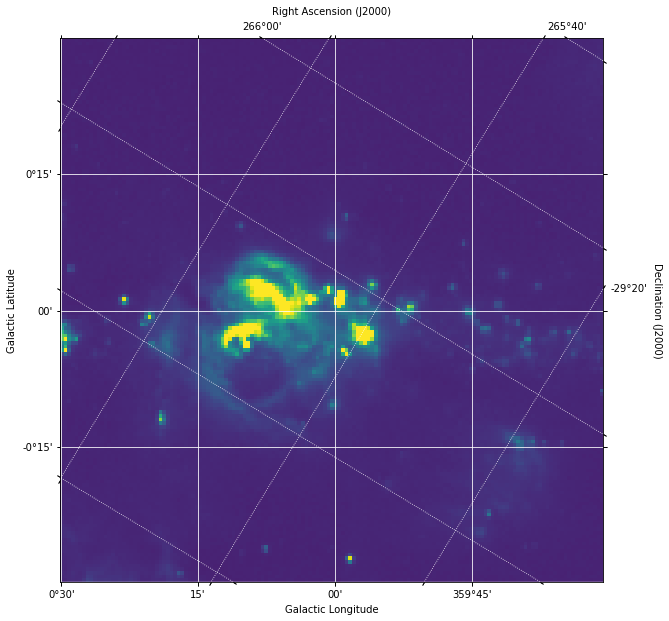

In [98]:
from astropy.utils.data import get_pkg_data_filename

filename = get_pkg_data_filename('galactic_center/gc_msx_e.fits')

hdu = fits.open(filename)[0]
wcs = WCS(hdu.header)

fig,ax = plt.subplots(1,1,subplot_kw={'projection':wcs, 
                                      'label':'overlays'}, 
                      figsize=(10,10))
ax.imshow(hdu.data, vmin=-2.e-5, vmax=2.e-4, origin='lower')

ax.coords.grid(True, color='white', ls='solid')
ax.coords[0].set_axislabel('Galactic Longitude')
ax.coords[1].set_axislabel('Galactic Latitude')

overlay = ax.get_coords_overlay('fk5')
overlay.grid(color='white', ls='dotted')
overlay[0].set_axislabel('Right Ascension (J2000)')
overlay[1].set_axislabel('Declination (J2000)')

In [74]:
hdu.info()

Filename: /astro/users/suberlak/.astropy/cache/download/py3/40e0d23b52c236c6bc4840edbc6e57c0
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      24   (149, 149)   float64   


In [76]:
hdu[0].header

SIMPLE  =                    T                                                  
BITPIX  =                  -64                                                  
NAXIS   =                    2                                                  
NAXIS1  =                  149                                                  
NAXIS2  =                  149                                                  
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
CRPIX1  =               75.907                                                  
CRVAL1  =                   0.                                                  
CDELT1  =      -0.006666666828                                                  
CTYPE1  = 'GLON-CAR'                                                            
CRPIX2  =              74.84

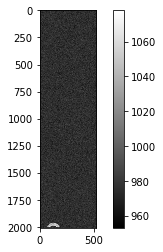

In [56]:
from astropy.coordinates import SkyCoord
from pyvo.dal import imagesearch

ModuleNotFoundError: No module named 'pyvo'